# Balanced Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the Balanced data set. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Balanced Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is worth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. The Focused dataset consists on the compilation of all data points that characterize as constraints. However, the model might lack the hability to predict the non-occurence of constraints, since the dataset is not balanced. To solve this problem, the dataset is balanced by randomly sampling the non-constraint data points.

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

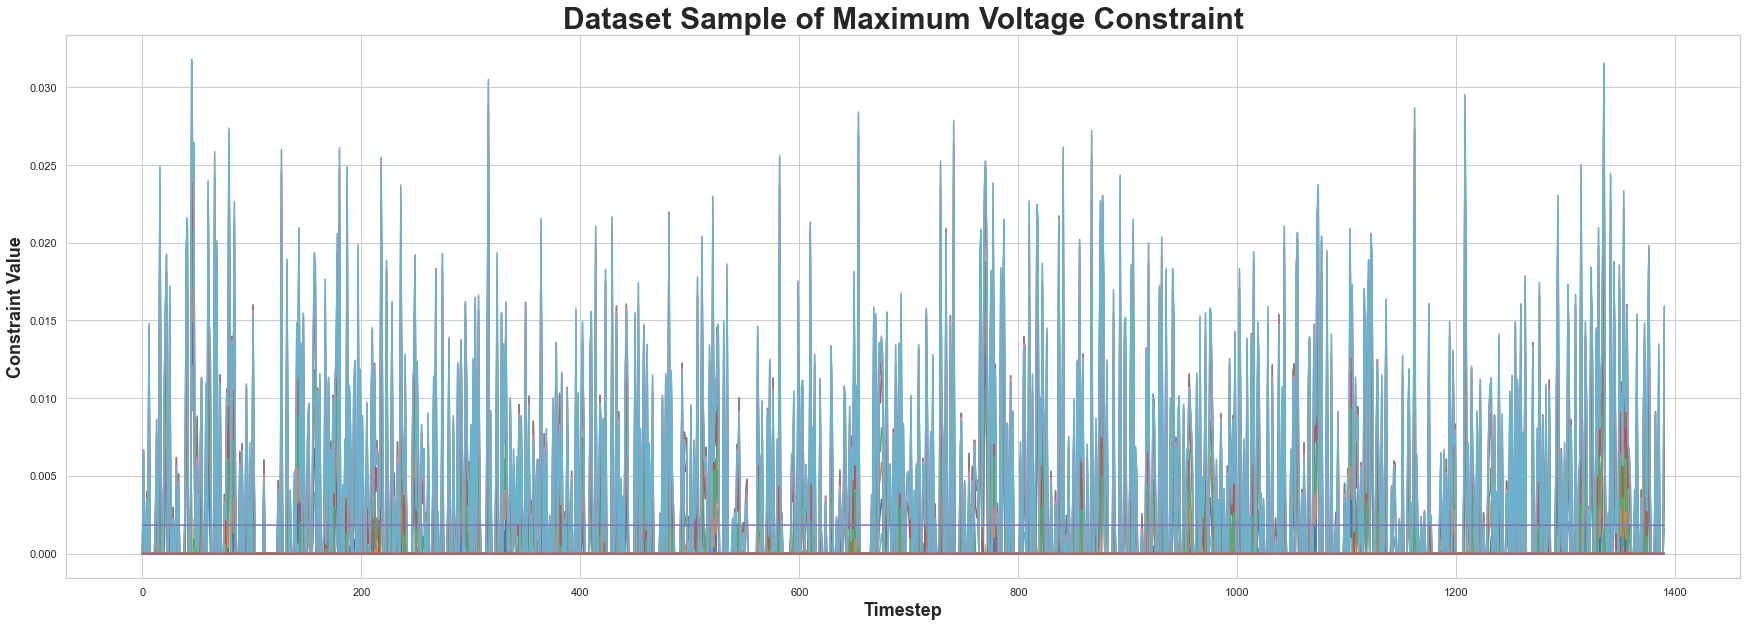

In [2]:
y_max_u_balanced = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
exogenous_data_vm_pu_max_balanced = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data_vm_pu_max_balanced, y_max_u_balanced)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [3]:
import optuna 
import os

import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [4]:
# General parameters
num_trials = 30

In [5]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.0644069763149719
0.05260425830867303


### Extreme Gradient Boosting Regressor

In [6]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 18:45:19,855] A new study created in memory with name: no-name-9eb0c635-0841-417e-88e2-f494fae5d138
[I 2022-10-14 18:46:12,558] Trial 0 finished with value: 0.2827463540050528 and parameters: {'booster': 'gblinear', 'lambda': 5.756554567867374e-07, 'alpha': 0.0008373564364550528, 'subsample': 0.7247019486676016, 'colsample_bytree': 0.6575469566140124}. Best is trial 0 with value: 0.2827463540050528.


true_positives_ctr:  4648
true_negatives_ctr:  273747
false_positives_ctr:  28800
false_negatives_ctr:  301
13724833866661542912


[I 2022-10-14 18:47:03,087] Trial 1 finished with value: 0.28502223259835474 and parameters: {'booster': 'gblinear', 'lambda': 1.471574997830259e-08, 'alpha': 1.3519070484996521e-08, 'subsample': 0.6605197966153074, 'colsample_bytree': 0.6395372574054609}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4622
true_negatives_ctr:  274552
false_positives_ctr:  27995
false_negatives_ctr:  327
13424430800085634329


[I 2022-10-14 18:48:09,848] Trial 2 finished with value: 0.0011729133964585347 and parameters: {'booster': 'gbtree', 'lambda': 0.010553632328210983, 'alpha': 2.080724247674281e-08, 'subsample': 0.9861652328631128, 'colsample_bytree': 0.3222835910578198, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.019796353939756314, 'gamma': 0.04978982122269293, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  39
false_positives_ctr:  302508
false_negatives_ctr:  0
17953920467069769


[I 2022-10-14 18:49:10,410] Trial 3 finished with value: 0.28219967104854293 and parameters: {'booster': 'gblinear', 'lambda': 1.558953926523526e-06, 'alpha': 0.0010522802716167686, 'subsample': 0.34885278931872044, 'colsample_bytree': 0.8450547289273134}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4655
true_negatives_ctr:  273530
false_positives_ctr:  29017
false_negatives_ctr:  294
13805455098023817984


[I 2022-10-14 18:51:58,454] Trial 4 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.008733035171054657, 'alpha': 5.1447103813507965e-06, 'subsample': 0.9464378511541018, 'colsample_bytree': 0.27437721038021545, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0006752787364767272, 'gamma': 0.1776817939336275, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2668908032139661, 'skip_drop': 0.01514996872144344}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:53:07,905] Trial 5 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.09326509779310949, 'alpha': 2.6910678331580492e-08, 'subsample': 0.8041431115128328, 'colsample_bytree': 0.6141640147916161, 'max_depth': 7, 'min_child_weight': 7, 'eta': 2.3808830497406295e-08, 'gamma': 2.6244696570836786e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:55:38,102] Trial 6 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0007938182623438121, 'alpha': 8.22773547799141e-08, 'subsample': 0.2394408659662003, 'colsample_bytree': 0.8935161169073012, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.10539325393482e-08, 'gamma': 0.03190975384352959, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.09341320053771453, 'skip_drop': 0.9960167896899152}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:59:43,684] Trial 7 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0016912495122494726, 'alpha': 0.15442631196422607, 'subsample': 0.7288557258394168, 'colsample_bytree': 0.9004331193579314, 'max_depth': 7, 'min_child_weight': 6, 'eta': 1.0786637056832769e-07, 'gamma': 1.297035808894318e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.899617517699665e-06, 'skip_drop': 0.008982655709502498}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:00:56,736] Trial 8 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 3.3093161886928837e-07, 'alpha': 0.0037327513586746315, 'subsample': 0.5297606724977167, 'colsample_bytree': 0.3219646729807639, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.0409825815449453e-06, 'gamma': 7.62776698926466e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:04:28,458] Trial 9 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.0734657117717339e-07, 'alpha': 1.6432607494280986e-05, 'subsample': 0.5917151387053692, 'colsample_bytree': 0.8546453273390047, 'max_depth': 7, 'min_child_weight': 7, 'eta': 3.9178919076870926e-06, 'gamma': 0.00039533669115736115, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.02144793872436803, 'skip_drop': 1.5266935582259033e-06}. Best is trial 1 with value: 0.28502223259835474.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:05:17,880] Trial 10 finished with value: 0.2853701908116333 and parameters: {'booster': 'gblinear', 'lambda': 1.1963061292896451e-08, 'alpha': 1.0961253080296877e-06, 'subsample': 0.44217883246172474, 'colsample_bytree': 0.4861039236907012}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4636
true_negatives_ctr:  274382
false_positives_ctr:  28165
false_negatives_ctr:  313
13491124291034856585


[I 2022-10-14 19:06:12,910] Trial 11 finished with value: 0.28401616797717477 and parameters: {'booster': 'gblinear', 'lambda': 1.2036455491446265e-08, 'alpha': 7.461989509005888e-07, 'subsample': 0.4543699412091665, 'colsample_bytree': 0.47727188038732005}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4617
true_negatives_ctr:  274438
false_positives_ctr:  28109
false_negatives_ctr:  332
13463951684649771060


[I 2022-10-14 19:07:05,288] Trial 12 finished with value: 0.28396705137473977 and parameters: {'booster': 'gblinear', 'lambda': 9.395445476598793e-06, 'alpha': 7.02667488014215e-07, 'subsample': 0.46556437571224296, 'colsample_bytree': 0.4872918629017738}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4618
true_negatives_ctr:  274410
false_positives_ctr:  28137
false_negatives_ctr:  331
13474460423190344865


[I 2022-10-14 19:07:57,728] Trial 13 finished with value: 0.28434859099514653 and parameters: {'booster': 'gblinear', 'lambda': 1.4326485156791916e-08, 'alpha': 3.219327438660027e-07, 'subsample': 0.3454848767595757, 'colsample_bytree': 0.7244637710716654}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4622
true_negatives_ctr:  274417
false_positives_ctr:  28130
false_negatives_ctr:  327
13473373429096635264


[I 2022-10-14 19:08:50,069] Trial 14 finished with value: 0.28397584427906014 and parameters: {'booster': 'gblinear', 'lambda': 1.609231029220375e-05, 'alpha': 1.5885509071201542e-05, 'subsample': 0.6642597002942455, 'colsample_bytree': 0.48634118988387}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4621
true_negatives_ctr:  274360
false_positives_ctr:  28187
false_negatives_ctr:  328
13493659541511002112


[I 2022-10-14 19:09:42,763] Trial 15 finished with value: 0.2840008964792461 and parameters: {'booster': 'gblinear', 'lambda': 3.714315518461563e-08, 'alpha': 1.294206911498905e-08, 'subsample': 0.8442586529628171, 'colsample_bytree': 0.7458552808112611}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4623
true_negatives_ctr:  274329
false_positives_ctr:  28218
false_negatives_ctr:  326
13505609460170095065


[I 2022-10-14 19:10:36,429] Trial 16 finished with value: 0.28425068759469185 and parameters: {'booster': 'gblinear', 'lambda': 3.9512654735247684e-05, 'alpha': 3.0228916263768566e-06, 'subsample': 0.5959224923213851, 'colsample_bytree': 0.4017259744788282}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4619
true_negatives_ctr:  274448
false_positives_ctr:  28099
false_negatives_ctr:  330
13461052279091440212


[I 2022-10-14 19:11:28,809] Trial 17 finished with value: 0.28350863272145954 and parameters: {'booster': 'gblinear', 'lambda': 2.6227595180090844e-06, 'alpha': 0.00012292824099528028, 'subsample': 0.40084880453534255, 'colsample_bytree': 0.5529277095323608}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4619
true_negatives_ctr:  274321
false_positives_ctr:  28226
false_negatives_ctr:  330
13507057713557920785


[I 2022-10-14 19:12:21,857] Trial 18 finished with value: 0.28405165658018683 and parameters: {'booster': 'gblinear', 'lambda': 1.2024816344597226e-07, 'alpha': 1.3449140152513267e-07, 'subsample': 0.28329913522663014, 'colsample_bytree': 0.20466652505924798}. Best is trial 10 with value: 0.2853701908116333.


true_positives_ctr:  4614
true_negatives_ctr:  274491
false_positives_ctr:  28056
false_negatives_ctr:  335
13443651820985338260


[I 2022-10-14 19:13:24,898] Trial 19 finished with value: 0.3764098440290061 and parameters: {'booster': 'gbtree', 'lambda': 0.3145268125960782, 'alpha': 0.32983251513649775, 'subsample': 0.5334474582818662, 'colsample_bytree': 0.7242296373277604, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.5382452045176536, 'gamma': 1.0885604105625649e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.3764098440290061.


true_positives_ctr:  3765
true_negatives_ctr:  293706
false_positives_ctr:  8841
false_negatives_ctr:  1184
5566057044789184020


[I 2022-10-14 19:14:28,125] Trial 20 finished with value: 0.48158255510238984 and parameters: {'booster': 'gbtree', 'lambda': 0.5702977329678042, 'alpha': 0.6971990965025907, 'subsample': 0.519389336178378, 'colsample_bytree': 0.7745680533810885, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.1136408583923578, 'gamma': 2.307344162082628e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4023
true_negatives_ctr:  296892
false_positives_ctr:  5655
false_negatives_ctr:  926
4315656451257328212


[I 2022-10-14 19:15:31,238] Trial 21 finished with value: 0.33723538333816305 and parameters: {'booster': 'gbtree', 'lambda': 0.35064086307982256, 'alpha': 0.9967968638820897, 'subsample': 0.5112944866571836, 'colsample_bytree': 0.7048711028980633, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.9003122865117981, 'gamma': 1.4291556889661104e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  3936
true_negatives_ctr:  289609
false_positives_ctr:  12938
false_negatives_ctr:  1013
7342717786689969684


[I 2022-10-14 19:16:39,053] Trial 22 finished with value: 0.32878084505264693 and parameters: {'booster': 'gbtree', 'lambda': 0.2655429320907821, 'alpha': 0.9250660868997506, 'subsample': 0.5423347157477202, 'colsample_bytree': 0.9772862442915657, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.8702065613061831, 'gamma': 1.769446033087114e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  3673
true_negatives_ctr:  291375
false_positives_ctr:  11172
false_negatives_ctr:  1276
6504898420937596785


[I 2022-10-14 19:17:43,097] Trial 23 finished with value: 0.25453349239602696 and parameters: {'booster': 'gbtree', 'lambda': 0.7020546372542338, 'alpha': 0.04491516801748063, 'subsample': 0.5268469870551473, 'colsample_bytree': 0.7497049250861989, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.9008622303809012, 'gamma': 2.973719679381748e-07, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  3577
true_negatives_ctr:  284920
false_positives_ctr:  17627
false_negatives_ctr:  1372
9089443883909403504


[I 2022-10-14 19:18:44,855] Trial 24 finished with value: 0.4262848134132529 and parameters: {'booster': 'gbtree', 'lambda': 0.052474494271730454, 'alpha': 0.03900134690821949, 'subsample': 0.503004526270023, 'colsample_bytree': 0.7864031781460766, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.029354100009394802, 'gamma': 1.1563963997176646e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4702
true_negatives_ctr:  289763
false_positives_ctr:  12784
false_negatives_ctr:  247
7593006157777130580


[I 2022-10-14 19:19:50,295] Trial 25 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.048682919922692074, 'alpha': 0.028269624950564298, 'subsample': 0.38794467097015056, 'colsample_bytree': 0.8046647381332198, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.015622870989922743, 'gamma': 1.0054838895693589e-06, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:20:58,462] Trial 26 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.06293366621092772, 'alpha': 0.19434698521743027, 'subsample': 0.6451986755374449, 'colsample_bytree': 0.9771075649999521, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.017129385687507024, 'gamma': 1.2121476462391331e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:22:00,734] Trial 27 finished with value: 0.4773077410751023 and parameters: {'booster': 'gbtree', 'lambda': 0.00044989413339393164, 'alpha': 0.008509839161512446, 'subsample': 0.4862142839477279, 'colsample_bytree': 0.796243645707409, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.0633905817201731, 'gamma': 1.62246683434091e-06, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4170
true_negatives_ctr:  296021
false_positives_ctr:  6526
false_negatives_ctr:  779
4753304053284998400


[I 2022-10-14 19:23:02,016] Trial 28 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0003580143383895917, 'alpha': 0.013718645813723479, 'subsample': 0.31481817916039456, 'colsample_bytree': 0.8043302680292602, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.0010836959742830232, 'gamma': 3.7108165753109778e-06, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.48158255510238984.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:24:03,542] Trial 29 finished with value: 0.4839568035603736 and parameters: {'booster': 'gbtree', 'lambda': 0.008167318096972869, 'alpha': 0.0041212794678690615, 'subsample': 0.7060626389309919, 'colsample_bytree': 0.6814493375822792, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.061150803597910613, 'gamma': 1.338263587057604e-07, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.4839568035603736.


true_positives_ctr:  4189
true_negatives_ctr:  296176
false_positives_ctr:  6371
false_negatives_ctr:  760
4695016001960148480
Number of finished trials:  30
Best trial:
  Value: 0.4839568035603736
  Params: 
    booster: gbtree
    lambda: 0.008167318096972869
    alpha: 0.0041212794678690615
    subsample: 0.7060626389309919
    colsample_bytree: 0.6814493375822792
    max_depth: 3
    min_child_weight: 5
    eta: 0.061150803597910613
    gamma: 1.338263587057604e-07
    grow_policy: lossguide


In [7]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 19:24:03,621] A new study created in memory with name: no-name-55192161-07ba-49d5-9f21-717900a87892
[I 2022-10-14 19:25:28,303] Trial 0 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.3168252976736448, 'alpha': 3.650159403401554e-06, 'subsample': 0.3287005841516748, 'colsample_bytree': 0.35043494018690124, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0006237009080714941, 'gamma': 2.552036875583588e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -1.0.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:29:35,505] Trial 1 finished with value: 0.423609410146226 and parameters: {'booster': 'dart', 'lambda': 0.002594977274239513, 'alpha': 2.152044991798022e-07, 'subsample': 0.6956193321841223, 'colsample_bytree': 0.7119938070071827, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.9475560895602488, 'gamma': 1.6724954373790456e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0004136623451020617, 'skip_drop': 1.5481935221742656e-08}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  3948
true_negatives_ctr:  296166
false_positives_ctr:  5308
false_negatives_ctr:  2074
5011639817591480320


[I 2022-10-14 19:30:29,318] Trial 2 finished with value: 0.2548996454249123 and parameters: {'booster': 'gblinear', 'lambda': 0.007974606131743485, 'alpha': 0.003548116150633247, 'subsample': 0.3918965594023046, 'colsample_bytree': 0.9076991048934915}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  4664
true_negatives_ctr:  275034
false_positives_ctr:  26440
false_negatives_ctr:  1358
15607463436253384704


[I 2022-10-14 19:35:07,730] Trial 3 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 8.620384206777364e-05, 'alpha': 0.0003291815365864623, 'subsample': 0.7878639267800809, 'colsample_bytree': 0.5529539178187474, 'max_depth': 9, 'min_child_weight': 9, 'eta': 7.437270797447278e-07, 'gamma': 0.00029870723428286817, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013911513084913603, 'skip_drop': 1.3867007203383665e-05}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:39:23,444] Trial 4 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 2.396321708115661e-06, 'alpha': 0.0030863142339134547, 'subsample': 0.7987400169571661, 'colsample_bytree': 0.21064089216316415, 'max_depth': 7, 'min_child_weight': 8, 'eta': 3.3194881593133126e-08, 'gamma': 9.842930457945714e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0386431642212085, 'skip_drop': 0.42728135832145453}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:40:31,906] Trial 5 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 3.228432633654211e-08, 'alpha': 0.033423963456920495, 'subsample': 0.7199218998578651, 'colsample_bytree': 0.47935833183438725, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.0012521880145856638, 'gamma': 0.009034080730851143, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:41:42,438] Trial 6 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 6.777262556554333e-07, 'alpha': 8.660944872812204e-05, 'subsample': 0.40214386511694156, 'colsample_bytree': 0.9957174529369863, 'max_depth': 3, 'min_child_weight': 2, 'eta': 3.649351812739718e-06, 'gamma': 0.0021637501558858124, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:42:38,225] Trial 7 finished with value: 0.3134285055493668 and parameters: {'booster': 'gblinear', 'lambda': 0.0025040328896853456, 'alpha': 2.1993227647486515e-05, 'subsample': 0.29806779553096097, 'colsample_bytree': 0.5002206471990132}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  4778
true_negatives_ctr:  282170
false_positives_ctr:  19304
false_negatives_ctr:  1244
12390946050546553744


[I 2022-10-14 19:44:17,002] Trial 8 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.7627922998042844e-08, 'alpha': 0.030683763597032534, 'subsample': 0.6759030551678047, 'colsample_bytree': 0.8421324969916903, 'max_depth': 9, 'min_child_weight': 3, 'eta': 8.75531557566102e-06, 'gamma': 9.667443512118393e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:45:34,459] Trial 9 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.2932137550205071, 'alpha': 1.2540474574021773e-07, 'subsample': 0.2439875429974535, 'colsample_bytree': 0.9187953129676119, 'max_depth': 7, 'min_child_weight': 3, 'eta': 8.505669493914326e-06, 'gamma': 9.787107950791433e-08, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.423609410146226.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:50:06,733] Trial 10 finished with value: 0.4887980309474949 and parameters: {'booster': 'dart', 'lambda': 0.0002922129086762905, 'alpha': 1.3097156879021484e-08, 'subsample': 0.9750799023416187, 'colsample_bytree': 0.7240467678408559, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.17876089217524246, 'gamma': 7.589039638662391e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.3086183465290436e-08, 'skip_drop': 1.3472132363461666e-08}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4837
true_negatives_ctr:  294493
false_positives_ctr:  6981
false_negatives_ctr:  1185
6343860319389578512


[I 2022-10-14 19:54:25,276] Trial 11 finished with value: 0.4477520847689805 and parameters: {'booster': 'dart', 'lambda': 0.0003750092255485348, 'alpha': 1.681735108408095e-08, 'subsample': 0.9970014389792426, 'colsample_bytree': 0.6983355654747876, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.6055421673852844, 'gamma': 4.3603109634811966e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2588020632314595e-08, 'skip_drop': 1.235953236020574e-08}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4288
true_negatives_ctr:  295438
false_positives_ctr:  6036
false_negatives_ctr:  1734
5569888449200123584


[I 2022-10-14 19:58:53,933] Trial 12 finished with value: 0.47742529253622246 and parameters: {'booster': 'dart', 'lambda': 9.700681396761717e-05, 'alpha': 1.0061717440931157e-08, 'subsample': 0.9921201309217368, 'colsample_bytree': 0.7157462372552854, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.25661128681775924, 'gamma': 0.7411481889166947, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.3712123546882908e-08, 'skip_drop': 1.1072664376652228e-08}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4825
true_negatives_ctr:  294070
false_positives_ctr:  7404
false_negatives_ctr:  1197
6555358855364089204


[I 2022-10-14 20:03:40,684] Trial 13 finished with value: 0.2826207312752346 and parameters: {'booster': 'dart', 'lambda': 3.624934615385624e-05, 'alpha': 1.1609471698669198e-08, 'subsample': 0.9933103332084985, 'colsample_bytree': 0.7071593447728273, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.022521821835872775, 'gamma': 0.08934247750920289, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.5736825849818655e-08, 'skip_drop': 6.235277712066378e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  5910
true_negatives_ctr:  259637
false_positives_ctr:  41837
false_negatives_ctr:  112
22515966210201223284


[I 2022-10-14 20:08:55,786] Trial 14 finished with value: 0.4480890211133577 and parameters: {'booster': 'dart', 'lambda': 4.1546239712153715e-06, 'alpha': 2.2714688246666985e-07, 'subsample': 0.8868940461059114, 'colsample_bytree': 0.7714064871555292, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.03197161144564716, 'gamma': 0.5365353507398268, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4082863377341967e-07, 'skip_drop': 0.008688501453737495}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  5458
true_negatives_ctr:  288789
false_positives_ctr:  12685
false_negatives_ctr:  564
9530763753454077012


[I 2022-10-14 20:13:31,864] Trial 15 finished with value: 0.39273808557104195 and parameters: {'booster': 'dart', 'lambda': 0.025638995119183276, 'alpha': 4.493984987872365e-06, 'subsample': 0.5538235282116275, 'colsample_bytree': 0.6214222200003561, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.028644441127802827, 'gamma': 3.434930361042773e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.47787891476245e-06, 'skip_drop': 1.066261306159179e-06}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  5512
true_negatives_ctr:  283735
false_positives_ctr:  17739
false_negatives_ctr:  510
11998448301784271860


[I 2022-10-14 20:18:40,014] Trial 16 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0003559563206673324, 'alpha': 0.7307802165918418, 'subsample': 0.8755387350155195, 'colsample_bytree': 0.6188308817823749, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.0017017096589267895, 'gamma': 0.00019523262669348394, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.743993856029346e-06, 'skip_drop': 1.0475389477649826e-08}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 20:19:43,138] Trial 17 finished with value: 0.33626429002157165 and parameters: {'booster': 'gblinear', 'lambda': 1.4743806062948027e-05, 'alpha': 1.4307912539298102e-06, 'subsample': 0.558051159312355, 'colsample_bytree': 0.8003407226000518}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4727
true_negatives_ctr:  284969
false_positives_ctr:  16505
false_negatives_ctr:  1295
11034388114135750144


[I 2022-10-14 20:24:20,479] Trial 18 finished with value: 0.48799816898803494 and parameters: {'booster': 'dart', 'lambda': 4.7337906801610747e-07, 'alpha': 4.363258124592723e-08, 'subsample': 0.9119726354221411, 'colsample_bytree': 0.3981181876155446, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.1231075429288541, 'gamma': 1.3092570693375654e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.512453964876706e-08, 'skip_drop': 6.93221023522886e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4889
true_negatives_ctr:  294258
false_positives_ctr:  7216
false_negatives_ctr:  1133
6491613687262227540


[I 2022-10-14 20:29:40,680] Trial 19 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.6993005368029662e-07, 'alpha': 8.653951180859976e-08, 'subsample': 0.8885938940140548, 'colsample_bytree': 0.37878484088756537, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.0001792989084455964, 'gamma': 5.901921210582338e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.316296617534825e-07, 'skip_drop': 7.108670531455711e-06}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 20:30:38,427] Trial 20 finished with value: 0.33779905848772596 and parameters: {'booster': 'gblinear', 'lambda': 3.7238281867928327e-07, 'alpha': 1.1398211619298735e-06, 'subsample': 0.8168908663877005, 'colsample_bytree': 0.23391774383303354}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4747
true_negatives_ctr:  284944
false_positives_ctr:  16530
false_negatives_ctr:  1275
11056036608485939764


[I 2022-10-14 20:33:44,562] Trial 21 finished with value: 0.4884416209848275 and parameters: {'booster': 'dart', 'lambda': 0.0003638896332214323, 'alpha': 1.2749023964128962e-08, 'subsample': 0.9498165605604613, 'colsample_bytree': 0.400129822163494, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.1460014414232145, 'gamma': 1.2925563183313869e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.4123647748496574e-08, 'skip_drop': 2.4407518774803836e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4854
true_negatives_ctr:  294463
false_positives_ctr:  7011
false_negatives_ctr:  1168
6368077342528196820


[I 2022-10-14 20:36:45,013] Trial 22 finished with value: 0.4863390469575643 and parameters: {'booster': 'dart', 'lambda': 8.025396995678441e-06, 'alpha': 4.9173360993770475e-08, 'subsample': 0.9140702516143369, 'colsample_bytree': 0.3930769267319456, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.10495174112535263, 'gamma': 1.8117996741047725e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.996147199338566e-07, 'skip_drop': 5.159080596099e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4921
true_negatives_ctr:  294033
false_positives_ctr:  7441
false_negatives_ctr:  1101
6623668634092913424


[I 2022-10-14 20:39:37,046] Trial 23 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0005895010364916567, 'alpha': 5.648950383438863e-07, 'subsample': 0.9326313832862677, 'colsample_bytree': 0.3128327499604416, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.0063571056650419955, 'gamma': 1.9325035225039068e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0112903643473782e-07, 'skip_drop': 2.128713947735447e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 20:42:30,747] Trial 24 finished with value: 0.4836435784410951 and parameters: {'booster': 'dart', 'lambda': 0.03332066877551176, 'alpha': 4.846709049284863e-08, 'subsample': 0.8191040110439596, 'colsample_bytree': 0.44319616391687533, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.13868702880196368, 'gamma': 1.570689493663054e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.4874827713181515e-05, 'skip_drop': 0.0001244122901342841}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4818
true_negatives_ctr:  294436
false_positives_ctr:  7038
false_negatives_ctr:  1204
6363440661117995520


[I 2022-10-14 20:45:22,243] Trial 25 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.001184666722957144, 'alpha': 4.778333828120204e-08, 'subsample': 0.9470509686899764, 'colsample_bytree': 0.28756847920323847, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.005976390716540953, 'gamma': 5.4315799158134014e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.126047595458987e-08, 'skip_drop': 1.3400178358221963e-07}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 20:48:39,997] Trial 26 finished with value: 0.4763762527048678 and parameters: {'booster': 'dart', 'lambda': 1.4129693453366807e-06, 'alpha': 4.514964927036851e-07, 'subsample': 0.6362551814606868, 'colsample_bytree': 0.5611607183960182, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.11005243007923653, 'gamma': 1.5027731271115763e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.2510704620781893e-06, 'skip_drop': 0.0001271284581219116}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4563
true_negatives_ctr:  295255
false_positives_ctr:  6219
false_negatives_ctr:  1459
5808018355950556944


[I 2022-10-14 20:55:29,707] Trial 27 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 2.2739546297073774e-05, 'alpha': 1.9464180021093778e-05, 'subsample': 0.7724840950724139, 'colsample_bytree': 0.4155308312278766, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.010717890535863823, 'gamma': 1.0732511190135597e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1475959966350368e-07, 'skip_drop': 6.8732202494764245e-06}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 20:56:23,890] Trial 28 finished with value: 0.3341989608465739 and parameters: {'booster': 'gblinear', 'lambda': 0.00014098655230136733, 'alpha': 2.6558507141447264e-08, 'subsample': 0.8558150719025814, 'colsample_bytree': 0.5282916197241821}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  4720
true_negatives_ctr:  284852
false_positives_ctr:  16622
false_negatives_ctr:  1302
11087293675224197904


[I 2022-10-14 20:59:32,963] Trial 29 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 7.601496859734513e-08, 'alpha': 2.171170944744275e-06, 'subsample': 0.7346684855817778, 'colsample_bytree': 0.3297124910774125, 'max_depth': 5, 'min_child_weight': 8, 'eta': 7.103861351838552e-05, 'gamma': 5.096477485846562e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006723821062354479, 'skip_drop': 8.682245579253193e-08}. Best is trial 10 with value: 0.4887980309474949.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0
Number of finished trials:  30
Best trial:
  Value: 0.4887980309474949
  Params: 
    booster: dart
    lambda: 0.0002922129086762905
    alpha: 1.3097156879021484e-08
    subsample: 0.9750799023416187
    colsample_bytree: 0.7240467678408559
    max_depth: 5
    min_child_weight: 10
    eta: 0.17876089217524246
    gamma: 7.589039638662391e-07
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 5.3086183465290436e-08
    skip_drop: 1.3472132363461666e-08


### Gradient Boosting Regressor

In [8]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 20:59:33,085] A new study created in memory with name: no-name-3a2ed4ec-ff0d-4140-af95-4acc5127d568
[I 2022-10-14 21:00:58,017] Trial 0 finished with value: 0.4751848120548711 and parameters: {'n_estimators': 117, 'learning_rate': 0.10692998254285567, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4751848120548711.


true_positives_ctr:  3931
true_negatives_ctr:  297171
false_positives_ctr:  5376
false_negatives_ctr:  1018
4155388535013252369


[I 2022-10-14 21:01:43,404] Trial 1 finished with value: 0.42406268912721296 and parameters: {'n_estimators': 10, 'learning_rate': 0.8385047350727417, 'loss': 'squared_error'}. Best is trial 0 with value: 0.4751848120548711.


true_positives_ctr:  3800
true_negatives_ctr:  295930
false_positives_ctr:  6617
false_negatives_ctr:  1149
4633668092364825129


[I 2022-10-14 21:02:46,433] Trial 2 finished with value: 0.49897041109570556 and parameters: {'n_estimators': 62, 'learning_rate': 0.19051350683610427, 'loss': 'squared_error'}. Best is trial 2 with value: 0.49897041109570556.


true_positives_ctr:  4008
true_negatives_ctr:  297545
false_positives_ctr:  5002
false_negatives_ctr:  941
4026790744876262580


[I 2022-10-14 21:04:16,633] Trial 3 finished with value: 0.4760566360377581 and parameters: {'n_estimators': 149, 'learning_rate': 0.17232833980746226, 'loss': 'squared_error'}. Best is trial 2 with value: 0.49897041109570556.


true_positives_ctr:  3965
true_negatives_ctr:  296974
false_positives_ctr:  5573
false_negatives_ctr:  984
4255226415144330612


[I 2022-10-14 21:05:13,361] Trial 4 finished with value: 0.46969495511893994 and parameters: {'n_estimators': 41, 'learning_rate': 0.41479362042554285, 'loss': 'squared_error'}. Best is trial 2 with value: 0.49897041109570556.


true_positives_ctr:  3938
true_negatives_ctr:  296888
false_positives_ctr:  5659
false_negatives_ctr:  1011
4280700514555895409


[I 2022-10-14 21:07:01,563] Trial 5 finished with value: 0.4675807766434526 and parameters: {'n_estimators': 206, 'learning_rate': 0.16110818317248615, 'loss': 'squared_error'}. Best is trial 2 with value: 0.49897041109570556.


true_positives_ctr:  3961
true_negatives_ctr:  296692
false_positives_ctr:  5855
false_negatives_ctr:  988
4375165758527168640


[I 2022-10-14 21:08:02,005] Trial 6 finished with value: 0.4736811660728177 and parameters: {'n_estimators': 45, 'learning_rate': 0.2994997720396465, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.49897041109570556.


true_positives_ctr:  3754
true_negatives_ctr:  297885
false_positives_ctr:  4662
false_negatives_ctr:  1195
3768802709887299840


[I 2022-10-14 21:09:08,290] Trial 7 finished with value: 0.5044945219909415 and parameters: {'n_estimators': 68, 'learning_rate': 0.15469822724518187, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  4081
true_negatives_ctr:  297396
false_positives_ctr:  5151
false_negatives_ctr:  868
4122939275714684544


[I 2022-10-14 21:10:02,670] Trial 8 finished with value: 0.3381299611395178 and parameters: {'n_estimators': 33, 'learning_rate': 0.8516677031165083, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3668
true_negatives_ctr:  292101
false_positives_ctr:  10446
false_negatives_ctr:  1281
6200031309889875444


[I 2022-10-14 21:10:49,484] Trial 9 finished with value: 0.487863920195171 and parameters: {'n_estimators': 31, 'learning_rate': 0.7168221981637606, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3665
true_negatives_ctr:  298609
false_positives_ctr:  3938
false_negatives_ctr:  1284
3413985120288002337


[I 2022-10-14 21:16:46,976] Trial 10 finished with value: 0.4820923404477535 and parameters: {'n_estimators': 914, 'learning_rate': 0.108471293626836, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3575
true_negatives_ctr:  298804
false_positives_ctr:  3743
false_negatives_ctr:  1374
3289134018742588212


[I 2022-10-14 21:19:26,892] Trial 11 finished with value: 0.38209035305005984 and parameters: {'n_estimators': 375, 'learning_rate': 0.22610567934244197, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3910
true_negatives_ctr:  292988
false_positives_ctr:  9559
false_negatives_ctr:  1039
5929702029563930289


[I 2022-10-14 21:20:25,725] Trial 12 finished with value: 0.502324604246517 and parameters: {'n_estimators': 66, 'learning_rate': 0.17226251386701583, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  4038
true_negatives_ctr:  297515
false_positives_ctr:  5032
false_negatives_ctr:  911
4052791388097653460


[I 2022-10-14 21:21:09,052] Trial 13 finished with value: 0.49560889412259773 and parameters: {'n_estimators': 13, 'learning_rate': 0.28491497968756146, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  4316
true_negatives_ctr:  295986
false_positives_ctr:  6561
false_negatives_ctr:  633
4830792681305675889


[I 2022-10-14 21:22:16,061] Trial 14 finished with value: 0.5016859366566787 and parameters: {'n_estimators': 77, 'learning_rate': 0.14266217796622288, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  4052
true_negatives_ctr:  297426
false_positives_ctr:  5121
false_negatives_ctr:  897
4097400687372333537


[I 2022-10-14 21:23:23,576] Trial 15 finished with value: 0.49231301927649995 and parameters: {'n_estimators': 20, 'learning_rate': 0.3932870500432255, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3976
true_negatives_ctr:  297492
false_positives_ctr:  5055
false_negatives_ctr:  973
4035892196296628745


[I 2022-10-14 21:25:25,483] Trial 16 finished with value: 0.42444903189110184 and parameters: {'n_estimators': 223, 'learning_rate': 0.22525793988203577, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3960
true_negatives_ctr:  294938
false_positives_ctr:  7609
false_negatives_ctr:  989
5126143000475899689


[I 2022-10-14 21:28:37,049] Trial 17 finished with value: 0.2792352398609637 and parameters: {'n_estimators': 414, 'learning_rate': 0.5201075062347058, 'loss': 'squared_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3824
true_negatives_ctr:  284878
false_positives_ctr:  17669
false_negatives_ctr:  1125
9204028018266530337


[I 2022-10-14 21:29:53,404] Trial 18 finished with value: 0.4765098400783996 and parameters: {'n_estimators': 85, 'learning_rate': 0.1267034127444512, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.5044945219909415.


true_positives_ctr:  3894
true_negatives_ctr:  297370
false_positives_ctr:  5177
false_negatives_ctr:  1055
4053224640815732025


[I 2022-10-14 21:30:42,035] Trial 19 finished with value: 0.506971321830518 and parameters: {'n_estimators': 20, 'learning_rate': 0.22467416227192083, 'loss': 'squared_error'}. Best is trial 19 with value: 0.506971321830518.


true_positives_ctr:  4258
true_negatives_ctr:  296660
false_positives_ctr:  5887
false_negatives_ctr:  691
4516809346425442185


[I 2022-10-14 21:31:29,718] Trial 20 finished with value: 0.5002380251195409 and parameters: {'n_estimators': 19, 'learning_rate': 0.22565370096136736, 'loss': 'squared_error'}. Best is trial 19 with value: 0.506971321830518.


true_positives_ctr:  4257
true_negatives_ctr:  296450
false_positives_ctr:  6097
false_negatives_ctr:  692
4606621259608391604


[I 2022-10-14 21:32:15,101] Trial 21 finished with value: 0.5078252181570717 and parameters: {'n_estimators': 21, 'learning_rate': 0.20398168715471215, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4332
true_negatives_ctr:  296333
false_positives_ctr:  6214
false_negatives_ctr:  617
4689012617041874100


[I 2022-10-14 21:32:59,250] Trial 22 finished with value: 0.5028806828955041 and parameters: {'n_estimators': 21, 'learning_rate': 0.2512021849657673, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4186
true_negatives_ctr:  296851
false_positives_ctr:  5696
false_negatives_ctr:  763
4403606571853359444


[I 2022-10-14 21:33:40,614] Trial 23 finished with value: 0.5051413823547565 and parameters: {'n_estimators': 14, 'learning_rate': 0.3625560241927109, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4157
true_negatives_ctr:  297065
false_positives_ctr:  5482
false_negatives_ctr:  792
4298828267653508169


[I 2022-10-14 21:34:22,658] Trial 24 finished with value: 0.4997006968077066 and parameters: {'n_estimators': 14, 'learning_rate': 0.4015988081774022, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4099
true_negatives_ctr:  297155
false_positives_ctr:  5392
false_negatives_ctr:  850
4234926028920416865


[I 2022-10-14 21:35:13,120] Trial 25 finished with value: 0.4838502858187615 and parameters: {'n_estimators': 25, 'learning_rate': 0.3440633893382614, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4053
true_negatives_ctr:  296889
false_positives_ctr:  5658
false_negatives_ctr:  896
4329892125940558905


[I 2022-10-14 21:35:57,900] Trial 26 finished with value: 0.4505047306387916 and parameters: {'n_estimators': 10, 'learning_rate': 0.5464349981282679, 'loss': 'absolute_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  3850
true_negatives_ctr:  296727
false_positives_ctr:  5820
false_negatives_ctr:  1099
4312204887490774260


[I 2022-10-14 21:36:37,298] Trial 27 finished with value: 0.46739477715190075 and parameters: {'n_estimators': 15, 'learning_rate': 0.5302099548879343, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  4006
true_negatives_ctr:  296487
false_positives_ctr:  6060
false_negatives_ctr:  943
4482827236000729140


[I 2022-10-14 21:37:33,995] Trial 28 finished with value: 0.4676476032522732 and parameters: {'n_estimators': 45, 'learning_rate': 0.3383289935781263, 'loss': 'squared_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  3963
true_negatives_ctr:  296718
false_positives_ctr:  5829
false_negatives_ctr:  986
4364820410411349504


[I 2022-10-14 21:38:26,595] Trial 29 finished with value: 0.46915414687303714 and parameters: {'n_estimators': 28, 'learning_rate': 0.25506434272616263, 'loss': 'absolute_error'}. Best is trial 21 with value: 0.5078252181570717.


true_positives_ctr:  3920
true_negatives_ctr:  297043
false_positives_ctr:  5504
false_negatives_ctr:  1029
4205975744057184384
Number of finished trials:  30
Best trial:
  Value: 0.5078252181570717
  Params: 
    n_estimators: 21
    learning_rate: 0.20398168715471215
    loss: squared_error


In [9]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 21:38:26,670] A new study created in memory with name: no-name-8d6c482f-7f2c-4180-8ef6-7188cdae0121
[I 2022-10-14 21:39:28,811] Trial 0 finished with value: 0.44576777563730174 and parameters: {'n_estimators': 33, 'learning_rate': 0.10352637644578058, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.44576777563730174.


true_positives_ctr:  4956
true_negatives_ctr:  291735
false_positives_ctr:  9739
false_negatives_ctr:  1066
7811469843275997460


[I 2022-10-14 21:40:11,636] Trial 1 finished with value: 0.41800121401938695 and parameters: {'n_estimators': 13, 'learning_rate': 0.11090012131113189, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.44576777563730174.


true_positives_ctr:  4566
true_negatives_ctr:  292532
false_positives_ctr:  8942
false_negatives_ctr:  1456
7209601661823582912


[I 2022-10-14 21:47:51,941] Trial 2 finished with value: 0.4352785326301373 and parameters: {'n_estimators': 825, 'learning_rate': 0.4115507985428135, 'loss': 'squared_error'}. Best is trial 0 with value: 0.44576777563730174.


true_positives_ctr:  4794
true_negatives_ctr:  292126
false_positives_ctr:  9348
false_negatives_ctr:  1228
7531707781465618704


[I 2022-10-14 21:54:26,403] Trial 3 finished with value: 0.435887776780843 and parameters: {'n_estimators': 692, 'learning_rate': 0.40761971696038957, 'loss': 'squared_error'}. Best is trial 0 with value: 0.44576777563730174.


true_positives_ctr:  4821
true_negatives_ctr:  292000
false_positives_ctr:  9474
false_negatives_ctr:  1201
7609221412053370260


[I 2022-10-14 21:55:14,923] Trial 4 finished with value: 0.4567239713004732 and parameters: {'n_estimators': 17, 'learning_rate': 0.26055098172821295, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  4975
true_negatives_ctr:  292176
false_positives_ctr:  9298
false_negatives_ctr:  1047
7598080893452968212


[I 2022-10-14 21:57:35,313] Trial 5 finished with value: 0.4248181737487699 and parameters: {'n_estimators': 170, 'learning_rate': 0.9164772951667769, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  4806
true_negatives_ctr:  291446
false_positives_ctr:  10028
false_negatives_ctr:  1216
7881615155816398224


[I 2022-10-14 22:05:13,534] Trial 6 finished with value: 0.42972408124129974 and parameters: {'n_estimators': 739, 'learning_rate': 0.7101300066316913, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  4839
true_negatives_ctr:  291490
false_positives_ctr:  9984
false_negatives_ctr:  1183
7876066644108328212


[I 2022-10-14 22:12:55,664] Trial 7 finished with value: 0.4296183332313617 and parameters: {'n_estimators': 720, 'learning_rate': 0.1620054272915444, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  4846
true_negatives_ctr:  291476
false_positives_ctr:  9998
false_negatives_ctr:  1176
7886658876119139264


[I 2022-10-14 22:13:54,987] Trial 8 finished with value: 0.44635518973290167 and parameters: {'n_estimators': 37, 'learning_rate': 0.10591538579131134, 'loss': 'squared_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  5380
true_negatives_ctr:  289105
false_positives_ctr:  12369
false_negatives_ctr:  642
9336486033512375284


[I 2022-10-14 22:14:51,980] Trial 9 finished with value: 0.434371397242656 and parameters: {'n_estimators': 25, 'learning_rate': 0.12062539408569455, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.4567239713004732.


true_positives_ctr:  4955
true_negatives_ctr:  291090
false_positives_ctr:  10384
false_negatives_ctr:  1067
8135869207384731444


[I 2022-10-14 22:16:33,477] Trial 10 finished with value: 0.45908073203149485 and parameters: {'n_estimators': 110, 'learning_rate': 0.25852395504752856, 'loss': 'squared_error'}. Best is trial 10 with value: 0.45908073203149485.


true_positives_ctr:  5235
true_negatives_ctr:  290822
false_positives_ctr:  10652
false_negatives_ctr:  787
8410725004059162324


[I 2022-10-14 22:18:25,192] Trial 11 finished with value: 0.4601635174089477 and parameters: {'n_estimators': 131, 'learning_rate': 0.22357050777358212, 'loss': 'squared_error'}. Best is trial 11 with value: 0.4601635174089477.


true_positives_ctr:  5199
true_negatives_ctr:  291107
false_positives_ctr:  10367
false_negatives_ctr:  823
8249855995422938640


[I 2022-10-14 22:20:25,583] Trial 12 finished with value: 0.46096836375219463 and parameters: {'n_estimators': 118, 'learning_rate': 0.2317532187255205, 'loss': 'squared_error'}. Best is trial 12 with value: 0.46096836375219463.


true_positives_ctr:  5183
true_negatives_ctr:  291232
false_positives_ctr:  10242
false_negatives_ctr:  839
8179075643751834900


[I 2022-10-14 22:23:25,796] Trial 13 finished with value: 0.4620265121481132 and parameters: {'n_estimators': 242, 'learning_rate': 0.18299596839846274, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5114
true_negatives_ctr:  291671
false_positives_ctr:  9803
false_negatives_ctr:  908
7923467034357471604


[I 2022-10-14 22:26:38,497] Trial 14 finished with value: 0.45455187159455307 and parameters: {'n_estimators': 260, 'learning_rate': 0.16644751670639693, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5109
true_negatives_ctr:  291298
false_positives_ctr:  10176
false_negatives_ctr:  913
8108725859547777780


[I 2022-10-14 22:30:13,658] Trial 15 finished with value: 0.457613908024339 and parameters: {'n_estimators': 300, 'learning_rate': 0.1786148747109895, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5085
true_negatives_ctr:  291597
false_positives_ctr:  9877
false_negatives_ctr:  937
7946147354735515024


[I 2022-10-14 22:31:37,494] Trial 16 finished with value: 0.454193012574258 and parameters: {'n_estimators': 66, 'learning_rate': 0.44365329476973847, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5148
true_negatives_ctr:  291099
false_positives_ctr:  10375
false_negatives_ctr:  874
8228278148522468212


[I 2022-10-14 22:33:01,966] Trial 17 finished with value: 0.45663513606094547 and parameters: {'n_estimators': 67, 'learning_rate': 0.3294915797084849, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5205
true_negatives_ctr:  290846
false_positives_ctr:  10628
false_negatives_ctr:  817
8383689103379123412


[I 2022-10-14 22:37:01,797] Trial 18 finished with value: 0.45758427917507727 and parameters: {'n_estimators': 340, 'learning_rate': 0.1965116347478717, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5057
true_negatives_ctr:  291803
false_positives_ctr:  9671
false_negatives_ctr:  965
7828129397509184512


[I 2022-10-14 22:39:36,526] Trial 19 finished with value: 0.4602230742657647 and parameters: {'n_estimators': 192, 'learning_rate': 0.14911396086505785, 'loss': 'squared_error'}. Best is trial 13 with value: 0.4620265121481132.


true_positives_ctr:  5195
true_negatives_ctr:  291110
false_positives_ctr:  10364
false_negatives_ctr:  827
8246343780171759124


[I 2022-10-14 22:40:51,895] Trial 20 finished with value: 0.4632373773029313 and parameters: {'n_estimators': 68, 'learning_rate': 0.3157177843176609, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5228
true_negatives_ctr:  291081
false_positives_ctr:  10393
false_negatives_ctr:  794
8277445781621872500


[I 2022-10-14 22:42:00,847] Trial 21 finished with value: 0.45445321246073533 and parameters: {'n_estimators': 51, 'learning_rate': 0.3101837855832275, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5251
true_negatives_ctr:  290439
false_positives_ctr:  11035
false_negatives_ctr:  771
8610162128277073680


[I 2022-10-14 22:43:27,205] Trial 22 finished with value: 0.4327074384112281 and parameters: {'n_estimators': 86, 'learning_rate': 0.5395564445943275, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5011
true_negatives_ctr:  290679
false_positives_ctr:  10795
false_negatives_ctr:  1011
8370167182592155920


[I 2022-10-14 22:48:06,549] Trial 23 finished with value: 0.4513273391947147 and parameters: {'n_estimators': 442, 'learning_rate': 0.22303748547645438, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5012
true_negatives_ctr:  291741
false_positives_ctr:  9733
false_negatives_ctr:  1010
7836710048959195860


[I 2022-10-14 22:50:21,141] Trial 24 finished with value: 0.45246547559875766 and parameters: {'n_estimators': 183, 'learning_rate': 0.30035788883896847, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5018
true_negatives_ctr:  291713
false_positives_ctr:  9761
false_negatives_ctr:  1004
7853868203823092404


[I 2022-10-14 22:52:03,234] Trial 25 finished with value: 0.458721828701574 and parameters: {'n_estimators': 123, 'learning_rate': 0.14583052147039324, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5283
true_negatives_ctr:  290462
false_positives_ctr:  11012
false_negatives_ctr:  739
8614654043596906260


[I 2022-10-14 22:53:27,956] Trial 26 finished with value: 0.4628167174443473 and parameters: {'n_estimators': 82, 'learning_rate': 0.21797214056014744, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5283
true_negatives_ctr:  290736
false_positives_ctr:  10738
false_negatives_ctr:  739
8477768355449677300


[I 2022-10-14 22:54:30,675] Trial 27 finished with value: 0.4467542666808281 and parameters: {'n_estimators': 44, 'learning_rate': 0.36588936418962514, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5250
true_negatives_ctr:  289962
false_positives_ctr:  11512
false_negatives_ctr:  772
8847330972639863824


[I 2022-10-14 22:55:53,225] Trial 28 finished with value: 0.4555121025087639 and parameters: {'n_estimators': 81, 'learning_rate': 0.13320118250319604, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5327
true_negatives_ctr:  290023
false_positives_ctr:  11451
false_negatives_ctr:  695
8855288743204810512


[I 2022-10-14 22:56:42,776] Trial 29 finished with value: 0.4329517623692121 and parameters: {'n_estimators': 22, 'learning_rate': 0.518742564440851, 'loss': 'squared_error'}. Best is trial 20 with value: 0.4632373773029313.


true_positives_ctr:  5235
true_negatives_ctr:  289273
false_positives_ctr:  12201
false_negatives_ctr:  787
9181746908416236480
Number of finished trials:  30
Best trial:
  Value: 0.4632373773029313
  Params: 
    n_estimators: 68
    learning_rate: 0.3157177843176609
    loss: squared_error


### Support Vector Regressor

In [10]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 22:56:42,845] A new study created in memory with name: no-name-3632ae13-daff-4e60-9897-e469ae9f6710
[I 2022-10-14 22:57:42,010] Trial 0 finished with value: 0.15905856469076096 and parameters: {'kernel': 'poly', 'C': 0.0728967943124907, 'degree': 4, 'gamma': 0.0005637005356070915}. Best is trial 0 with value: 0.15905856469076096.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 22:58:36,714] Trial 1 finished with value: 0.15905856456862075 and parameters: {'kernel': 'poly', 'C': 1.2945946005603766e-08, 'degree': 4, 'gamma': 2.058334213732024e-08}. Best is trial 0 with value: 0.15905856469076096.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:00:16,771] Trial 2 finished with value: 0.15906136900237206 and parameters: {'kernel': 'rbf', 'C': 1.8072210030737085e-07, 'degree': 1, 'gamma': 4.905119215766277e-08}. Best is trial 2 with value: 0.15906136900237206.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:02:02,091] Trial 3 finished with value: 0.15906037773524861 and parameters: {'kernel': 'rbf', 'C': 2.8356948188181462e-08, 'degree': 5, 'gamma': 2.979378404971498e-06}. Best is trial 2 with value: 0.15906136900237206.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:03:46,067] Trial 4 finished with value: 0.1590904267225076 and parameters: {'kernel': 'rbf', 'C': 0.00987685540873988, 'degree': 2, 'gamma': 1.888719335660415e-05}. Best is trial 4 with value: 0.1590904267225076.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:05:20,572] Trial 5 finished with value: 0.1590585524777495 and parameters: {'kernel': 'rbf', 'C': 2.3751097383250586e-05, 'degree': 4, 'gamma': 8.17236540630505e-05}. Best is trial 4 with value: 0.1590904267225076.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:07:04,244] Trial 6 finished with value: 0.1590613690080593 and parameters: {'kernel': 'rbf', 'C': 5.799718066740717e-07, 'degree': 3, 'gamma': 8.289544982605606e-08}. Best is trial 4 with value: 0.1590904267225076.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:08:00,959] Trial 7 finished with value: 0.15986923862488744 and parameters: {'kernel': 'poly', 'C': 0.0049121149550401194, 'degree': 2, 'gamma': 0.01628821857223342}. Best is trial 7 with value: 0.15986923862488744.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:09:45,220] Trial 8 finished with value: 0.15907314582920695 and parameters: {'kernel': 'rbf', 'C': 0.003858404205105221, 'degree': 2, 'gamma': 1.934741470061529e-05}. Best is trial 7 with value: 0.15986923862488744.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:10:44,301] Trial 9 finished with value: 0.15905856472388327 and parameters: {'kernel': 'poly', 'C': 2.3493531598278515e-07, 'degree': 5, 'gamma': 0.02412903228643538}. Best is trial 7 with value: 0.15986923862488744.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:11:42,626] Trial 10 finished with value: 0.24867322267524938 and parameters: {'kernel': 'poly', 'C': 0.9548539949937317, 'degree': 1, 'gamma': 0.4990446441371546}. Best is trial 10 with value: 0.24867322267524938.


true_positives_ctr:  4948
true_negatives_ctr:  258519
false_positives_ctr:  44028
false_negatives_ctr:  1
18957792446584978560


[I 2022-10-14 23:12:41,245] Trial 11 finished with value: 0.24839746502019316 and parameters: {'kernel': 'poly', 'C': 0.4120678933801977, 'degree': 1, 'gamma': 0.8666823051446334}. Best is trial 10 with value: 0.24867322267524938.


true_positives_ctr:  4948
true_negatives_ctr:  258459
false_positives_ctr:  44088
false_negatives_ctr:  1
18976612134316789680


[I 2022-10-14 23:13:40,816] Trial 12 finished with value: 0.2490521964602148 and parameters: {'kernel': 'poly', 'C': 0.9258327353321972, 'degree': 1, 'gamma': 0.8267899178603114}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  258602
false_positives_ctr:  43945
false_negatives_ctr:  1
18931740773708372337


[I 2022-10-14 23:14:38,756] Trial 13 finished with value: 0.24860574482858816 and parameters: {'kernel': 'poly', 'C': 0.48111524793779364, 'degree': 1, 'gamma': 0.9464950791656691}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  258509
false_positives_ctr:  44038
false_negatives_ctr:  1
18960929809859498580


[I 2022-10-14 23:15:36,246] Trial 14 finished with value: 0.1593605784815675 and parameters: {'kernel': 'poly', 'C': 9.585414054849047e-05, 'degree': 1, 'gamma': 0.03569929909554895}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:16:34,835] Trial 15 finished with value: 0.15922152500643744 and parameters: {'kernel': 'poly', 'C': 0.03927561119700999, 'degree': 2, 'gamma': 0.002460484132554421}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:17:31,131] Trial 16 finished with value: 0.16283014161364126 and parameters: {'kernel': 'poly', 'C': 0.0005550721098882072, 'degree': 3, 'gamma': 0.15954370826110825}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:18:25,350] Trial 17 finished with value: 0.21102331557768433 and parameters: {'kernel': 'poly', 'C': 0.8287241694851268, 'degree': 1, 'gamma': 0.0027922190749884723}. Best is trial 12 with value: 0.2490521964602148.


true_positives_ctr:  4948
true_negatives_ctr:  244257
false_positives_ctr:  58290
false_negatives_ctr:  1
23127954682924122612


[I 2022-10-14 23:19:21,209] Trial 18 finished with value: 0.2542030253981351 and parameters: {'kernel': 'poly', 'C': 0.07838916427626133, 'degree': 3, 'gamma': 0.20602534741749612}. Best is trial 18 with value: 0.2542030253981351.


true_positives_ctr:  4939
true_negatives_ctr:  258695
false_positives_ctr:  43852
false_negatives_ctr:  10
18899697210724767465


[I 2022-10-14 23:20:13,545] Trial 19 finished with value: 0.23424276709299427 and parameters: {'kernel': 'poly', 'C': 0.05169684069562308, 'degree': 3, 'gamma': 0.12314018901461847}. Best is trial 18 with value: 0.2542030253981351.


true_positives_ctr:  4946
true_negatives_ctr:  252586
false_positives_ctr:  49961
false_negatives_ctr:  3
20765981066116149969


[I 2022-10-14 23:21:17,150] Trial 20 finished with value: 0.15905856675077917 and parameters: {'kernel': 'poly', 'C': 0.0008909005361323479, 'degree': 4, 'gamma': 0.0034855780026841645}. Best is trial 18 with value: 0.2542030253981351.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:22:08,642] Trial 21 finished with value: 0.26430078437774857 and parameters: {'kernel': 'poly', 'C': 0.12718215624115348, 'degree': 2, 'gamma': 0.20113015057397432}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4941
true_negatives_ctr:  261877
false_positives_ctr:  40670
false_negatives_ctr:  8
17885064997817358705


[I 2022-10-14 23:23:00,893] Trial 22 finished with value: 0.25243473309279923 and parameters: {'kernel': 'poly', 'C': 0.13637915070761106, 'degree': 2, 'gamma': 0.11264322016262407}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4946
true_negatives_ctr:  258504
false_positives_ctr:  44043
false_negatives_ctr:  3
18961870960446955569


[I 2022-10-14 23:23:53,674] Trial 23 finished with value: 0.23412195199881905 and parameters: {'kernel': 'poly', 'C': 0.12350126680627589, 'degree': 3, 'gamma': 0.09161002468759151}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4946
true_negatives_ctr:  252551
false_positives_ctr:  49996
false_negatives_ctr:  3
20776338891275392404


[I 2022-10-14 23:24:52,453] Trial 24 finished with value: 0.1590584689581203 and parameters: {'kernel': 'poly', 'C': 5.863228570314037e-06, 'degree': 2, 'gamma': 0.007934302094769472}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:25:50,384] Trial 25 finished with value: 0.15905856935600562 and parameters: {'kernel': 'poly', 'C': 0.010964125765331822, 'degree': 3, 'gamma': 0.0005228850065227656}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:26:45,556] Trial 26 finished with value: 0.1717341736315038 and parameters: {'kernel': 'poly', 'C': 0.0007584653998546681, 'degree': 2, 'gamma': 0.16342817576003335}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  223124
false_positives_ctr:  79423
false_negatives_ctr:  1
28187186873588150625


[I 2022-10-14 23:27:45,290] Trial 27 finished with value: 0.15905876541941433 and parameters: {'kernel': 'poly', 'C': 0.19355117224836918, 'degree': 3, 'gamma': 0.0006977906117618491}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 23:28:44,422] Trial 28 finished with value: 0.20153093442841166 and parameters: {'kernel': 'poly', 'C': 0.02350435253852817, 'degree': 2, 'gamma': 0.05786901659246791}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  239662
false_positives_ctr:  62885
false_negatives_ctr:  1
24341779315525303737


[I 2022-10-14 23:29:42,761] Trial 29 finished with value: 0.15905856456862122 and parameters: {'kernel': 'poly', 'C': 0.10958409932735377, 'degree': 3, 'gamma': 1.1495356861060674e-06}. Best is trial 21 with value: 0.26430078437774857.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920
Number of finished trials:  30
Best trial:
  Value: 0.26430078437774857
  Params: 
    kernel: poly
    C: 0.12718215624115348
    degree: 2
    gamma: 0.20113015057397432


In [11]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 23:29:42,845] A new study created in memory with name: no-name-d55e5d5f-6ec8-43fc-ab61-850981fe0514
[I 2022-10-14 23:31:54,250] Trial 0 finished with value: 0.20000214785190146 and parameters: {'kernel': 'rbf', 'C': 4.487238412226315e-06, 'degree': 4, 'gamma': 2.522748253955612e-07}. Best is trial 0 with value: 0.20000214785190146.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:33:06,240] Trial 1 finished with value: 0.19999883732488008 and parameters: {'kernel': 'poly', 'C': 9.507099044452003e-08, 'degree': 5, 'gamma': 0.03595474752444482}. Best is trial 0 with value: 0.20000214785190146.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:34:18,232] Trial 2 finished with value: 0.1999988372334655 and parameters: {'kernel': 'poly', 'C': 3.385178876993429e-07, 'degree': 1, 'gamma': 4.7776591036730824e-06}. Best is trial 0 with value: 0.20000214785190146.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:36:18,255] Trial 3 finished with value: 0.20000180377195978 and parameters: {'kernel': 'rbf', 'C': 0.010626095497181099, 'degree': 1, 'gamma': 2.3847038695057072e-08}. Best is trial 0 with value: 0.20000214785190146.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:38:29,263] Trial 4 finished with value: 0.19999954282729523 and parameters: {'kernel': 'rbf', 'C': 0.00010654314618509842, 'degree': 5, 'gamma': 6.785212479713898e-07}. Best is trial 0 with value: 0.20000214785190146.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:39:35,361] Trial 5 finished with value: 0.23362688145685415 and parameters: {'kernel': 'poly', 'C': 0.013241955473626457, 'degree': 4, 'gamma': 0.1704133880224551}. Best is trial 5 with value: 0.23362688145685415.


true_positives_ctr:  6011
true_negatives_ctr:  240651
false_positives_ctr:  60823
false_negatives_ctr:  11
29200856516500366224


[I 2022-10-14 23:40:46,995] Trial 6 finished with value: 0.19999883720648787 and parameters: {'kernel': 'poly', 'C': 7.47450768924888e-05, 'degree': 2, 'gamma': 1.626350696837816e-08}. Best is trial 5 with value: 0.23362688145685415.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:42:01,362] Trial 7 finished with value: 0.19999883720648787 and parameters: {'kernel': 'poly', 'C': 6.477739849942587e-08, 'degree': 5, 'gamma': 5.395912953216424e-06}. Best is trial 5 with value: 0.23362688145685415.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:43:15,616] Trial 8 finished with value: 0.19999883720648787 and parameters: {'kernel': 'poly', 'C': 0.002588171717298151, 'degree': 5, 'gamma': 3.296832967692731e-08}. Best is trial 5 with value: 0.23362688145685415.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:44:23,838] Trial 9 finished with value: 0.1999988372065774 and parameters: {'kernel': 'poly', 'C': 9.877302444229457e-05, 'degree': 2, 'gamma': 2.6217035810261106e-06}. Best is trial 5 with value: 0.23362688145685415.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:45:51,718] Trial 10 finished with value: 0.38429288695879776 and parameters: {'kernel': 'rbf', 'C': 0.6423136823025961, 'degree': 3, 'gamma': 0.850714117864058}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  5462
true_negatives_ctr:  282033
false_positives_ctr:  19441
false_negatives_ctr:  560
12776258285213973012


[I 2022-10-14 23:47:19,121] Trial 11 finished with value: 0.37716864887518053 and parameters: {'kernel': 'rbf', 'C': 0.500959089769331, 'degree': 3, 'gamma': 0.9051462508376894}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  5523
true_negatives_ctr:  280601
false_positives_ctr:  20873
false_negatives_ctr:  499
13470681869549476800


[I 2022-10-14 23:49:17,255] Trial 12 finished with value: 0.21901109170763122 and parameters: {'kernel': 'rbf', 'C': 0.9515615574803165, 'degree': 3, 'gamma': 0.0016230110260770313}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6011
true_negatives_ctr:  235036
false_positives_ctr:  66438
false_negatives_ctr:  11
30915603041291832084


[I 2022-10-14 23:50:47,912] Trial 13 finished with value: 0.3797206303330368 and parameters: {'kernel': 'rbf', 'C': 0.9689687270285141, 'degree': 3, 'gamma': 0.6210866173347874}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  5507
true_negatives_ctr:  281105
false_positives_ctr:  20369
false_negatives_ctr:  515
13229738228502343360


[I 2022-10-14 23:52:51,047] Trial 14 finished with value: 0.2057356044089743 and parameters: {'kernel': 'rbf', 'C': 0.09109987222711191, 'degree': 2, 'gamma': 0.001688845736466278}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6015
true_negatives_ctr:  228445
false_positives_ctr:  73029
false_negatives_ctr:  7
32783437419147920064


[I 2022-10-14 23:54:51,689] Trial 15 finished with value: 0.21596251704720945 and parameters: {'kernel': 'rbf', 'C': 0.06218662078798186, 'degree': 4, 'gamma': 0.010956593755040961}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6011
true_negatives_ctr:  233487
false_positives_ctr:  67987
false_negatives_ctr:  11
31368500688670685712


[I 2022-10-14 23:56:46,140] Trial 16 finished with value: 0.20396600310389645 and parameters: {'kernel': 'rbf', 'C': 0.0005912626702182555, 'degree': 3, 'gamma': 0.9748074701510994}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 23:58:55,915] Trial 17 finished with value: 0.200126892551715 and parameters: {'kernel': 'rbf', 'C': 0.06535748782521429, 'degree': 2, 'gamma': 5.613242279012621e-05}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 00:00:43,507] Trial 18 finished with value: 0.33877213670586576 and parameters: {'kernel': 'rbf', 'C': 0.9395974522247198, 'degree': 4, 'gamma': 0.05542101362342356}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  5691
true_negatives_ctr:  274336
false_positives_ctr:  27138
false_negatives_ctr:  331
16370228913280247604


[I 2022-10-15 00:02:53,804] Trial 19 finished with value: 0.19999933021265004 and parameters: {'kernel': 'rbf', 'C': 4.288232894023015e-06, 'degree': 3, 'gamma': 0.002842505082426118}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 00:05:01,543] Trial 20 finished with value: 0.20038611765247483 and parameters: {'kernel': 'rbf', 'C': 0.17008799595897636, 'degree': 3, 'gamma': 8.056469400511544e-05}. Best is trial 10 with value: 0.38429288695879776.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 00:06:29,558] Trial 21 finished with value: 0.401093359751433 and parameters: {'kernel': 'rbf', 'C': 0.9252894942327481, 'degree': 3, 'gamma': 0.8732520645536056}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  5342
true_negatives_ctr:  284885
false_positives_ctr:  16589
false_negatives_ctr:  680
11369831455254874420


[I 2022-10-15 00:08:15,900] Trial 22 finished with value: 0.26765979731375533 and parameters: {'kernel': 'rbf', 'C': 0.013229220235648048, 'degree': 3, 'gamma': 0.22781686279103072}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6004
true_negatives_ctr:  252946
false_positives_ctr:  48528
false_negatives_ctr:  18
25043830768458506944


[I 2022-10-15 00:10:00,432] Trial 23 finished with value: 0.3560658776924556 and parameters: {'kernel': 'rbf', 'C': 0.17454524834774596, 'degree': 2, 'gamma': 0.17815831887424005}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  5827
true_negatives_ctr:  275249
false_positives_ctr:  26225
false_negatives_ctr:  195
16027990084129193664


[I 2022-10-15 00:12:06,523] Trial 24 finished with value: 0.20080133100497538 and parameters: {'kernel': 'rbf', 'C': 0.0011668304776688947, 'degree': 4, 'gamma': 0.03057073029590564}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 00:13:40,265] Trial 25 finished with value: 0.331256215770199 and parameters: {'kernel': 'rbf', 'C': 0.029138639813172492, 'degree': 3, 'gamma': 0.9955230600549526}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  5980
true_negatives_ctr:  268327
false_positives_ctr:  33147
false_negatives_ctr:  42
19063362781106601364


[I 2022-10-15 00:15:32,512] Trial 26 finished with value: 0.24694196034853294 and parameters: {'kernel': 'rbf', 'C': 0.4546202193658812, 'degree': 3, 'gamma': 0.015325954922198912}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6011
true_negatives_ctr:  246164
false_positives_ctr:  55310
false_negatives_ctr:  11
27405882385438690900


[I 2022-10-15 00:17:41,750] Trial 27 finished with value: 0.19999883742848298 and parameters: {'kernel': 'rbf', 'C': 1.1618502773396298e-08, 'degree': 2, 'gamma': 0.0005725830058128826}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 00:19:36,723] Trial 28 finished with value: 0.2178935994336217 and parameters: {'kernel': 'rbf', 'C': 0.0026233554585764116, 'degree': 4, 'gamma': 0.16983527382792504}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6015
true_negatives_ctr:  233803
false_positives_ctr:  67671
false_negatives_ctr:  7
31277978593970286480


[I 2022-10-15 00:21:35,995] Trial 29 finished with value: 0.21984873993761955 and parameters: {'kernel': 'rbf', 'C': 0.2742509288443944, 'degree': 4, 'gamma': 0.005326901937509132}. Best is trial 21 with value: 0.401093359751433.


true_positives_ctr:  6011
true_negatives_ctr:  235331
false_positives_ctr:  66143
false_negatives_ctr:  11
30828363162764901904
Number of finished trials:  30
Best trial:
  Value: 0.401093359751433
  Params: 
    kernel: rbf
    C: 0.9252894942327481
    degree: 3
    gamma: 0.8732520645536056


# Extreme Gradient Boost Classifier

In [12]:
def objective(trial):
    # import data
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    #y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 00:21:36,085] A new study created in memory with name: no-name-7fbadbe3-3d54-4728-b7b3-58bb615731b6
[I 2022-10-15 00:21:45,143] Trial 0 finished with value: 0.5050568320545182 and parameters: {'booster': 'gbtree', 'lambda': 0.18008265819032993, 'alpha': 0.000689692908017674, 'subsample': 0.578669326263993, 'colsample_bytree': 0.8497774485352976, 'max_depth': 3, 'min_child_weight': 10, 'eta': 2.6638014833967545e-07, 'gamma': 0.00031704841057665856, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5050568320545182.
[I 2022-10-15 00:21:47,932] Trial 1 finished with value: 0.555381859946675 and parameters: {'booster': 'gblinear', 'lambda': 5.933567840792063e-08, 'alpha': 0.00036063827743768924, 'subsample': 0.7865781369245621, 'colsample_bytree': 0.7076016565175625}. Best is trial 1 with value: 0.555381859946675.
[I 2022-10-15 00:21:50,394] Trial 2 finished with value: 0.5594524272259555 and parameters: {'booster': 'gblinear', 'lambda': 2.8240099503183795e-08, 'alph

Number of finished trials:  30
Best trial:
  Value: 0.5717356124026731
  Params: 
    booster: dart
    lambda: 2.85687087746957e-05
    alpha: 4.268573683338325e-07
    subsample: 0.20810381463860617
    colsample_bytree: 0.9792160801334051
    max_depth: 5
    min_child_weight: 7
    eta: 0.023969127046449854
    gamma: 0.004738402349773698
    grow_policy: depthwise
    sample_type: weighted
    normalize_type: forest
    rate_drop: 0.007236341952383948
    skip_drop: 0.04176956206129261


In [13]:
def objective(trial):
    # import data
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    #y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 00:37:43,501] A new study created in memory with name: no-name-41806959-740c-442a-b66c-c2a2642def55
[I 2022-10-15 00:38:06,360] Trial 0 finished with value: 0.4527643423705977 and parameters: {'booster': 'gbtree', 'lambda': 1.261719798579172e-06, 'alpha': 7.54621679626648e-08, 'subsample': 0.5136670405721842, 'colsample_bytree': 0.6307865215834298, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.6190129567233152, 'gamma': 4.092916069443066e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.4527643423705977.
[I 2022-10-15 00:39:02,666] Trial 1 finished with value: 0.5006717960649892 and parameters: {'booster': 'dart', 'lambda': 0.0062240274862862205, 'alpha': 5.798999051558097e-07, 'subsample': 0.7983347345946408, 'colsample_bytree': 0.6318202396788793, 'max_depth': 3, 'min_child_weight': 6, 'eta': 5.064961588142111e-07, 'gamma': 1.5635683122180603e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26672020721

Number of finished trials:  30
Best trial:
  Value: 0.51854146742908
  Params: 
    booster: dart
    lambda: 0.587721636101038
    alpha: 8.116836546510032e-08
    subsample: 0.30001373029183576
    colsample_bytree: 0.934259683157665
    max_depth: 9
    min_child_weight: 4
    eta: 0.03554583223437679
    gamma: 2.5847353265807752e-05
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: forest
    rate_drop: 0.00017712652644811492
    skip_drop: 0.0482931841714364


## Grandient Boost Classifier


In [14]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    #y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 01:03:42,037] A new study created in memory with name: no-name-9ea363b2-0d1b-41f3-bcbe-2e5fbe7991f4
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprec

Number of finished trials:  30
Best trial:
  Value: 0.5976797387425418
  Params: 
    n_estimators: 995
    learning_rate: 0.23436353762112205
    loss: exponential


In [15]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    #y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 01:54:31,002] A new study created in memory with name: no-name-61ed407a-3c81-4a5c-b254-82910f6be83d
[I 2022-10-15 01:57:53,323] Trial 0 finished with value: 0.48889663929105337 and parameters: {'n_estimators': 417, 'learning_rate': 0.3337770871465659, 'loss': 'exponential'}. Best is trial 0 with value: 0.48889663929105337.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  wa

Number of finished trials:  30
Best trial:
  Value: 0.5181265127139792
  Params: 
    n_estimators: 48
    learning_rate: 0.2816150436071759
    loss: exponential


## Support Vector Classifier

In [16]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    #y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # print(valid_y)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 02:23:12,316] A new study created in memory with name: no-name-a2d1a072-bc55-4ad7-a384-c265842aae42
[I 2022-10-15 02:23:44,524] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 0.6348269412779707, 'degree': 5, 'gamma': 0.0021663350819037617}. Best is trial 0 with value: 0.0.
[I 2022-10-15 02:25:38,157] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 8.959046765192117e-08, 'degree': 5, 'gamma': 0.0003130164714262389}. Best is trial 0 with value: 0.0.
[I 2022-10-15 02:26:06,995] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 2.9664413200673443e-06, 'degree': 2, 'gamma': 5.909853702487223e-08}. Best is trial 0 with value: 0.0.
[I 2022-10-15 02:26:38,866] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 9.557801648746895e-07, 'degree': 5, 'gamma': 0.028076398572038686}. Best is trial 0 with value: 0.0.
[I 2022-10-15 02:28:32,353] Trial 4 finished with value: 0.0 and parameters: {

Number of finished trials:  30
Best trial:
  Value: 0.6120893734766478
  Params: 
    kernel: poly
    C: 0.17255480828891023
    degree: 4
    gamma: 0.9210638718130492


In [17]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    #y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 02:44:53,841] A new study created in memory with name: no-name-f930505c-d7d4-4008-84a3-a96a6e8a166f
[I 2022-10-15 02:46:08,460] Trial 0 finished with value: 0.07595999722937721 and parameters: {'kernel': 'poly', 'C': 0.09250186981591445, 'degree': 2, 'gamma': 1.354690801651145e-08}. Best is trial 0 with value: 0.07595999722937721.
[I 2022-10-15 02:47:26,420] Trial 1 finished with value: 0.07595999722937721 and parameters: {'kernel': 'poly', 'C': 1.2637825800704488e-06, 'degree': 5, 'gamma': 0.003871822936269882}. Best is trial 0 with value: 0.07595999722937721.
[I 2022-10-15 02:51:12,229] Trial 2 finished with value: 0.07595999722937721 and parameters: {'kernel': 'rbf', 'C': 7.53739282833233e-08, 'degree': 1, 'gamma': 8.274161333072817e-08}. Best is trial 0 with value: 0.07595999722937721.
[I 2022-10-15 02:52:25,397] Trial 3 finished with value: 0.07595999722937721 and parameters: {'kernel': 'poly', 'C': 6.294409310027331e-08, 'degree': 1, 'gamma': 2.4675459578793212e-08}

Number of finished trials:  30
Best trial:
  Value: 0.4962625843229704
  Params: 
    kernel: rbf
    C: 0.978943216037039
    degree: 3
    gamma: 0.08136855364022827


In [18]:
import beepy
beepy.beep(6)